Objective: This is an exploratory analysis of a real life data. 

The dataset includes provider data for the payment measures and value of care.

In [1]:
import shap
import os
import joblib
import sys

import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

user = os.environ.get("USER")
sys.path.append(f"/Users/{user}/utils/")

from scipy.stats import chi2_contingency
from plot_univariates import plot_univariate

In [2]:
data_path_2019 = f"/Users/{user}/data/CostReport_2019_Final.csv"
data_path_2020 = f"/Users/{user}/data/CostReport_2020_Final.csv"
data_path_2021 = f"/Users/{user}/data/CostReport_2021_Final.csv"

In [3]:
def run_sql_query(sql_query, local_env):
    return ps.sqldf(sql_query, local_env)

def compute_summary_statistics(df, column):
    data = df[column].dropna()
 

    if len(data) > 0:
        data = np.sort(data)

        percentile_25 = data[int(0.25 * (len(data) - 1))]
        percentile_75 = data[int(0.75 * (len(data) - 1))]

        min_val = data[0]
        max_val = data[-1]
        avg_val = np.mean(data)
        median_val = np.median(data)
    else:
        min_val = np.nan
        max_val = np.nan
        avg_val = np.nan
        median_val = np.nan
        percentile_25 = np.nan
        percentile_75 = np.nan

    formatted_min_val = "{:.4f}".format(min_val)
    formatted_max_val = "{:.4f}".format(max_val)
    formatted_avg_val = "{:.4f}".format(avg_val)
    formatted_median_val = "{:.4f}".format(median_val)
    formatted_percentile_25 = "{:.4f}".format(percentile_25)
    formatted_percentile_75 = "{:.4f}".format(percentile_75)

    return formatted_min_val, formatted_max_val, formatted_avg_val, formatted_median_val, formatted_percentile_25, formatted_percentile_75
 

def plot_top_levels(df1, df2, baseline_features, label1, label2, top_level=5):
    for column_name in baseline_features:
        counts_df1 = df1[column_name].value_counts()
        counts_df2 = df2[column_name].value_counts()
        proportions_df1 = counts_df1 / counts_df1.sum()
        proportions_df2 = counts_df2 / counts_df2.sum()
 

        max_proportion = max(proportions_df1.max(), proportions_df2.max())
        y_axis_cap = max(max_proportion+0.1, 0.25)
        top_proportions_df1 = proportions_df1.nlargest(top_level)
        top_proportions_df2 = proportions_df2.nlargest(top_level)
        x1 = range(len(top_proportions_df1))
        x2 = range(len(top_proportions_df2))
        plt.figure(figsize=(16, 8))
        ax1 = plt.subplot(121)
        ax1.bar(x1, top_proportions_df1.values, label=label1)
        ax1.set_ylabel("Proportion")
        ax1.set_title(f"'{column_name}' Proportions: The Top {top_level} levels in {label1}")
        ax1.set_ylim(0, y_axis_cap)
        ax1.set_xticks(x1)
        ax1.set_xticklabels(top_proportions_df1.index, rotation=45, ha="right")
        ax1.legend()
        ax2 = plt.subplot(122)
        ax2.bar(x2, top_proportions_df2.values, color="orange", label=label2)
        ax2.set_ylabel("Proportion")
        ax2.set_title(f"'{column_name}' Proportions: The Top {top_level} levels in {label2}")
        ax2.set_ylim(0, y_axis_cap)
        ax2.set_xticks(x2)
        ax2.set_xticklabels(top_proportions_df2.index, rotation=45, ha="right")
        ax2.legend()
        for i, val in enumerate(top_proportions_df1.values):
            ax1.text(i, val, f"{val:.2%}", ha="center", va="bottom")
        for i, val in enumerate(top_proportions_df2.values):
            ax2.text(i, val, f"{val:.2%}", ha="center", va="bottom")
          

        plt.tight_layout()
#         plt.savefig(f"{plot_directory}{column_name}.png")
#         plt.close()
    
    # plt.tight_layout()
    plt.show()

### Load Dataset

In [4]:
df_2019 = pd.read_csv(data_path_2019, low_memory=False)
df_2020 = pd.read_csv(data_path_2020, low_memory=False)
df_2021 = pd.read_csv(data_path_2021, low_memory=False)

In [5]:
df_2019.columns.to_list() == df_2020.columns.to_list() == df_2021.columns.to_list()

True

In [6]:
df_merged = pd.concat([df_2019, df_2020, df_2021], axis=0)
df_merged.shape

(18230, 117)

In [7]:
df_merged.columns.to_list()

['rpt_rec_num',
 'Provider CCN',
 'Hospital Name',
 'Street Address',
 'City',
 'State Code',
 'Zip Code',
 'County',
 'Medicare CBSA Number',
 'Rural Versus Urban',
 'CCN Facility Type',
 'Provider Type',
 'Type of Control',
 'Fiscal Year Begin Date',
 'Fiscal Year End Date',
 'FTE - Employees on Payroll',
 'Number of Interns and Residents (FTE)',
 'Total Days Title V',
 'Total Days Title XVIII',
 'Total Days Title XIX',
 'Total Days (V + XVIII + XIX + Unknown)',
 'Number of Beds',
 'Total Bed Days Available',
 'Total Discharges Title V',
 'Total Discharges Title XVIII',
 'Total Discharges Title XIX',
 'Total Discharges (V + XVIII + XIX + Unknown)',
 'Number of Beds + Total for all Subproviders',
 'Hospital Total Days Title V For Adults & Peds',
 'Hospital Total Days Title XVIII For Adults & Peds',
 'Hospital Total Days Title XIX For Adults & Peds',
 'Hospital Total Days (V + XVIII + XIX + Unknown) For Adults & Peds',
 'Hospital Number of Beds For Adults & Peds',
 'Hospital Total Bed 

### Clean column name

In [8]:
df_merged.columns = df_merged.columns.str.replace(r"[ \(\)\+\&\:\-']", "_", regex=True)

In [9]:
df_merged.columns.to_list()

['rpt_rec_num',
 'Provider_CCN',
 'Hospital_Name',
 'Street_Address',
 'City',
 'State_Code',
 'Zip_Code',
 'County',
 'Medicare_CBSA_Number',
 'Rural_Versus_Urban',
 'CCN_Facility_Type',
 'Provider_Type',
 'Type_of_Control',
 'Fiscal_Year_Begin_Date',
 'Fiscal_Year_End_Date',
 'FTE___Employees_on_Payroll',
 'Number_of_Interns_and_Residents__FTE_',
 'Total_Days_Title_V',
 'Total_Days_Title_XVIII',
 'Total_Days_Title_XIX',
 'Total_Days__V___XVIII___XIX___Unknown_',
 'Number_of_Beds',
 'Total_Bed_Days_Available',
 'Total_Discharges_Title_V',
 'Total_Discharges_Title_XVIII',
 'Total_Discharges_Title_XIX',
 'Total_Discharges__V___XVIII___XIX___Unknown_',
 'Number_of_Beds___Total_for_all_Subproviders',
 'Hospital_Total_Days_Title_V_For_Adults___Peds',
 'Hospital_Total_Days_Title_XVIII_For_Adults___Peds',
 'Hospital_Total_Days_Title_XIX_For_Adults___Peds',
 'Hospital_Total_Days__V___XVIII___XIX___Unknown__For_Adults___Peds',
 'Hospital_Number_of_Beds_For_Adults___Peds',
 'Hospital_Total_Bed_

### Subsetting dataframe

In [10]:
query = """
SELECT * 
FROM df_merged 
WHERE Net_Income >= 0
"""

not_loss = run_sql_query(query, locals())
not_loss.shape

(12699, 117)

### Categorical Variables

In [11]:
columns_of_interest = [
 'Rural_Versus_Urban',
 'CCN_Facility_Type',
 'Provider_Type',
 'Type_of_Control',
 'Number_of_Beds___Total_for_all_Subproviders',
 'Hospital_Name',
 'State_Code',
 'County',
 'Zip_Code'
]

In [12]:
for i in columns_of_interest:
    print(f"Value distribution for {i}:")
    print(not_loss[i].value_counts())
    print()

Value distribution for Rural_Versus_Urban:
U    7208
R    5491
Name: Rural_Versus_Urban, dtype: int64

Value distribution for CCN_Facility_Type:
STH      6991
CAH      3097
PH        938
RH        781
LTCH      692
CH        158
ORD        23
RNMHC      19
Name: CCN_Facility_Type, dtype: int64

Value distribution for Provider_Type:
1    9966
4     938
5     781
2     691
7     158
9     117
3      29
6      19
Name: Provider_Type, dtype: int64

Value distribution for Type_of_Control:
2     5273
4     3132
1     1233
11     799
9      795
5      561
10     207
6      196
8      171
13     160
12     127
3       34
7       11
Name: Type_of_Control, dtype: int64

Value distribution for Number_of_Beds___Total_for_all_Subproviders:
25.0      1492
40.0       197
16.0       184
60.0       174
24.0       167
          ... 
1622.0       1
1318.0       1
741.0        1
607.0        1
1764.0       1
Name: Number_of_Beds___Total_for_all_Subproviders, Length: 893, dtype: int64

Value distribution f

#### Chi-square test

In [13]:
columns_to_analyze = columns_of_interest
df = not_loss.copy()

In [14]:
for i in range(len(columns_to_analyze)):
    for j in range(i+1, len(columns_to_analyze)):
        col1 = columns_to_analyze[i]
        col2 = columns_to_analyze[j]

        contingency_table = pd.crosstab(df[col1], df[col2])

        chi2, p, dof, expected = chi2_contingency(contingency_table)

        print(f"Chi-square test between {col1} and {col2}:")
        print("Chi-square statistic:", chi2)
        print("P-value:", p)
        print("Degrees of freedom:", dof)
        print("Expected frequencies:\n", expected)
        print("\n" + "-"*50 + "\n")

Chi-square test between Rural_Versus_Urban and CCN_Facility_Type:
Chi-square statistic: 4674.6261915773875
P-value: 0.0
Degrees of freedom: 7
Expected frequencies:
 [[1339.13119143   68.31860776  299.21820616    9.94511379  405.58768407
   337.70147256    8.21552878 3022.88219545]
 [1757.86880857   89.68139224  392.78179384   13.05488621  532.41231593
   443.29852744   10.78447122 3968.11780455]]

--------------------------------------------------

Chi-square test between Rural_Versus_Urban and Provider_Type:
Chi-square statistic: 1827.2206058158258
P-value: 0.0
Degrees of freedom: 7
Expected frequencies:
 [[4309.26104418  298.78580991   12.5394913   405.58768407  337.70147256
     8.21552878   68.31860776   50.59036145]
 [5656.73895582  392.21419009   16.4605087   532.41231593  443.29852744
    10.78447122   89.68139224   66.40963855]]

--------------------------------------------------

Chi-square test between Rural_Versus_Urban and Type_of_Control:
Chi-square statistic: 2293.1018033

### Plots

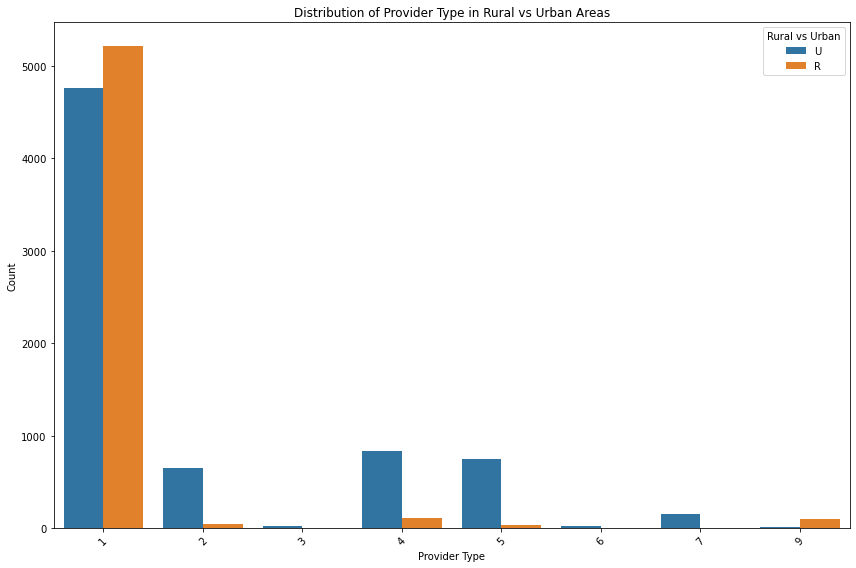

In [15]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Provider_Type', hue='Rural_Versus_Urban', data=not_loss)

plt.title('Distribution of Provider Type in Rural vs Urban Areas')
plt.xlabel('Provider Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Rural vs Urban')

plt.tight_layout()
plt.show()

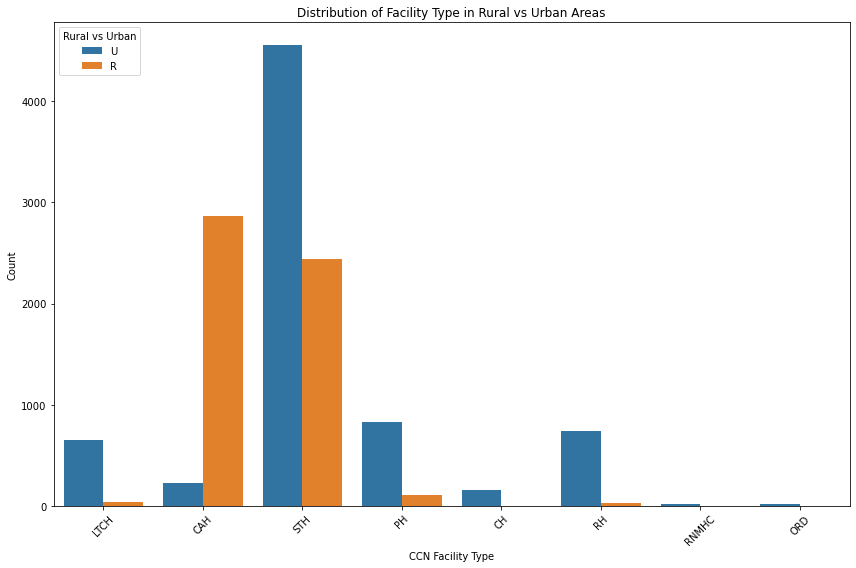

In [16]:
plt.figure(figsize=(12, 8))
sns.countplot(x='CCN_Facility_Type', hue='Rural_Versus_Urban', data=not_loss)

plt.title('Distribution of Facility Type in Rural vs Urban Areas')
plt.xlabel('CCN Facility Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Rural vs Urban')

plt.tight_layout()
plt.show()

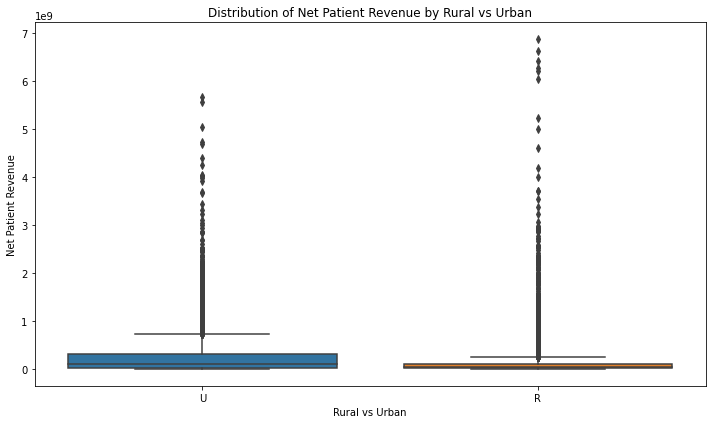

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rural_Versus_Urban', y='Net_Patient_Revenue', data=not_loss)

plt.title('Distribution of Net Patient Revenue by Rural vs Urban')
plt.xlabel('Rural vs Urban')
plt.ylabel('Net Patient Revenue')
plt.tight_layout()
plt.show()

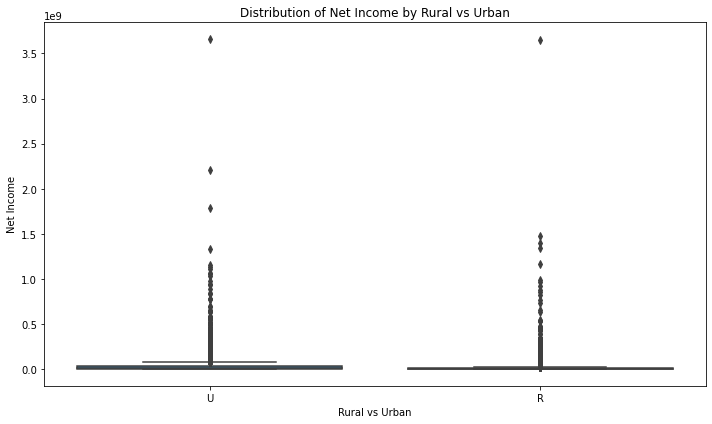

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rural_Versus_Urban', y='Net_Income', data=not_loss)

plt.title('Distribution of Net Income by Rural vs Urban')
plt.xlabel('Rural vs Urban')
plt.ylabel('Net Income')
plt.tight_layout()
plt.show()

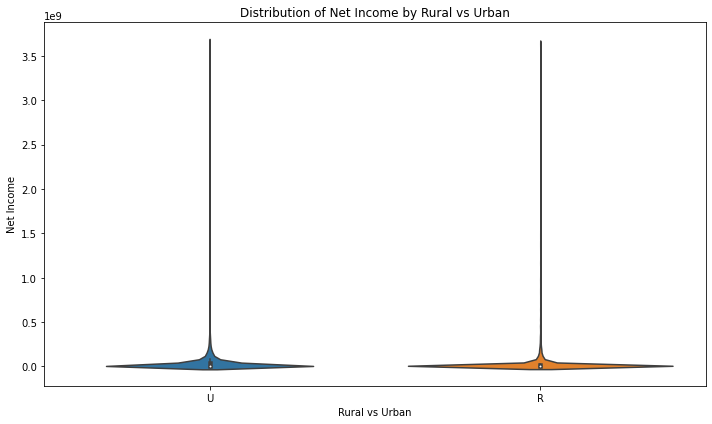

In [19]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Rural_Versus_Urban', y='Net_Income', data=not_loss)

plt.title('Distribution of Net Income by Rural vs Urban')
plt.xlabel('Rural vs Urban')
plt.ylabel('Net Income')
plt.tight_layout()
plt.show()

### Financial Analysis

In [20]:
cost_revenue_analysis = not_loss[['Provider_CCN', 'Total_Income', 'Total_Costs', 'Net_Income']].copy()
cost_revenue_analysis['Profit_Margin'] = (cost_revenue_analysis['Net_Income'] / cost_revenue_analysis['Total_Income']) * 100

cost_revenue_analysis = cost_revenue_analysis.sort_values(by='Profit_Margin', ascending=True)

print("Cost and Revenue Analysis:")
print(cost_revenue_analysis.head())

Cost and Revenue Analysis:
       Provider_CCN  Total_Income  Total_Costs  Net_Income  Profit_Margin
599          110031      -53412.0  133339788.0   3609956.0   -6758.698420
3973         500124     -729155.0  508969704.0  25268800.0   -3465.490876
8177         340064     -215902.0   73663413.0   4072296.0   -1886.177988
6629         330090     -364417.0  231637193.0   6302828.0   -1729.564757
12646        330191     -298520.0  311110167.0   4673096.0   -1565.421412


In [21]:
uncompensated_care_analysis = not_loss[['Provider_CCN', 'Cost_of_Uncompensated_Care', 'Total_Bad_Debt_Expense']].copy()
uncompensated_care_analysis['Uncompensated_Care_Percentage'] = (uncompensated_care_analysis['Cost_of_Uncompensated_Care'] / (df['Total_Costs'])) * 100

uncompensated_care_analysis = uncompensated_care_analysis.sort_values(by='Uncompensated_Care_Percentage', ascending=True)

print("Uncompensated Care Analysis:")
print(uncompensated_care_analysis[uncompensated_care_analysis['Uncompensated_Care_Percentage']>=0].head())

Uncompensated Care Analysis:
       Provider_CCN  Cost_of_Uncompensated_Care  Total_Bad_Debt_Expense  \
11281        400124                         9.0                    11.0   
4787         670280                         1.0                     NaN   
8709          33040                        37.0                     NaN   
7863         393302                      1124.0                     NaN   
9717         393302                      2218.0                     NaN   

       Uncompensated_Care_Percentage  
11281                       0.000013  
4787                        0.000014  
8709                        0.000178  
7863                        0.000257  
9717                        0.000482  


In [22]:
charge_ratio_analysis = not_loss[['Provider_CCN', 'Cost_To_Charge_Ratio']].copy()
charge_ratio_analysis['Cost_To_Charge_Ratio_Percentage'] = charge_ratio_analysis['Cost_To_Charge_Ratio'] * 100

charge_ratio_analysis = charge_ratio_analysis.sort_values(by='Cost_To_Charge_Ratio_Percentage', ascending=True)


print("Charge Ratio Analysis:")
print(charge_ratio_analysis.head())

Charge Ratio Analysis:
       Provider_CCN  Cost_To_Charge_Ratio  Cost_To_Charge_Ratio_Percentage
4787         670280              0.046039                           4.6039
4951         140040              0.046611                           4.6611
11020        100180              0.053519                           5.3519
12624        310044              0.054645                           5.4645
12628        310092              0.054725                           5.4725


### Quality of Care Analysis

### Operational Analysis

### Geographic and Demographic Factors

### Regulatory and Policy Impact